# A2D2 Visualization and Labeling

![](display_images/reinvent_logo.png)

Welcome to the End to End 3D ML workshop on [SageMaker](https://aws.amazon.com/sagemaker/). In this workshop we'll be walking through
how to parse a 3D dataset, visualize/label it, train a model on it, then deploy our model as a SageMaker endpoint
for inference. For the workshop, we'll be working with the [A2D2 driving dataset](https://www.a2d2.audi/a2d2/en.html),
which provides both 3D lidar and 2D camera data for a variety of driving scenes.

This workshop is split across three notebooks:

1. 1_vizualization.ipynb: Download and visualize the dataset.
2. 2_sagemaker_training.ipynb: train a 3D object detection model on the dataset.
3. 3_inference_byom.ipynb: Deploy an asynchronous SageMaker endpoint and run inference on the trained model.

In this notebook we'll look at how to interpret the A2D2 dataset structure
and how to add additional labels to the dataset.

#### 1) Download the A2D2 dataset

First we'll download the dataset to our [Amazon FSx filesystem](https://aws.amazon.com/fsx/lustre/) for fast training.

#### 2) Visualize the dataset in 2D and 3D

In this section we'll understand the dataset contents and visualize them in 2D and 3D.

#### 3) Verify the dataset's sensor fusion for labeling

We'll then project points from 3D to 2D to verify we're interpreting the positions and orientations of sensors correctly before sending the data for labeling in SageMaker Ground Truth.

#### 4) Convert the dataset to SageMaker Ground Truth format and kickoff a labeling job

Finally we'll convert a scene to a SageMaker Ground Truth input manifest that can be labeled by a worker. *Note that we won't be able to start
the SageMaker Ground Truth labeling job during the workshop, however this step can be configured and run in your own account*.

Let's start by installing a visualization library and importing a few others:

In [ ]:
!pip install pytransform3d

In [1]:
import os
import boto3
import sagemaker

from pathlib import Path
from pprint import pprint
import json

import matplotlib.pyplot as plt
from pytransform3d import rotations as pr
from pytransform3d import transformations as pt
from pytransform3d.transform_manager import TransformManager
from pytransform3d import plot_utils
from PIL import Image
import cv2
from datetime import datetime

import numpy as np


sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
region = boto3.session.Session().region_name
role = sagemaker.get_execution_role()

dataset_root_path = Path("../fsx/a2d2")

## Dataset Download

We'll download the object detection subset of A2D2 to your local notebook instance
for visualization and inspection before training. This process will take a few minutes.

In [ ]:
%%time

!mkdir -p {str(dataset_root_path)}
!aws s3 cp s3://aev-autonomous-driving-dataset/cams_lidars.json {str(dataset_root_path)}    
!aws s3 cp s3://aws-tc-largeobjects/DEV-AWS-MO-Nvidia/a2d2_gt_database.tar.gz {str(dataset_root_path)}
!aws s3 cp s3://aws-tc-largeobjects/DEV-AWS-MO-Nvidia/camera_lidar_semantic_bboxes.tar {str(dataset_root_path)}
!tar -C {str(dataset_root_path)} -xf ../fsx/a2d2/camera_lidar_semantic_bboxes.tar

## Downloaded Files

We've downloaded the 3D object detection dataset from A2D2 into the directory `a2d2/camera_lidar_semantic_bboxes`. You can read more about this dataset in the [README](https://aev-autonomous-driving-dataset.s3.eu-central-1.amazonaws.com/README-3DBoxes.txt).


Under the path `camera_lidar_semantic_bboxes` we find a flat list of scenes.
A scene is a short recording of sensor data from our autonomous vehicle. A2D2 provides 18 of these scenes for us to train on, all identified
by unique dates.

In [6]:
!ls {str(dataset_root_path)}/camera_lidar_semantic_bboxes

20180807_145028  20180925_135056  20181107_133258  20181204_135952
20180810_142822  20181008_095521  20181108_084007  20181204_154421
20180925_101535  20181016_125231  20181108_091945  20181204_170238
20180925_112730  20181107_132300  20181108_103155  class_list.json
20180925_124435  20181107_132730  20181108_123750  LICENSE


Each scene contains 2D camera data, 2D labels, 3D cuboid annotations, and 3D point clouds.

In [7]:
!ls {str(dataset_root_path)}/camera_lidar_semantic_bboxes/20180807_145028/

camera	label  label3D	lidar


We're interested specifically in the `camera`, `label3D`, and `lidar` folders as they contain
the data we'll be using for training.


Camera images are stored under the `camera` path as `png` files.


`camera/cam_front_center/<scene_id>_cam_front_center_<ts>.png`


3D point clouds (arrays of X,Y,Z points) are provided inside these compressed numpy structs.


`lidar/cam_front_center/<scene_id>_cam_front_center_<ts>.npz`


Finally our the labels we'll use for training are stored within the `label3D` folder inside json files.


`label3D/cam_front_center/<scene_id>_cam_front_center_<ts>.json`

## A2D2 Sensor Setup

In addition to our dataset, we also downloaded `cams_lidars.json` which contains the translation and orientation of each sensor relative to the vehicle's
[coordinate frame](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-point-cloud-sensor-fusion-details.html#sms-point-cloud-world-coordinate-system).


We'll refer to this translation and orientation of each sensor as the sensor "pose." A sensor's pose is nicely described by a single 4x4 matrix known as 
the rigid body [transformation matrix](https://en.wikipedia.org/wiki/Transformation_matrix). If you have a 3x3 rotation matrix `R` and a translation vector `T`, the transformation matrix is simply `[R T; 0 0 0 1]`. In the context of A2D2, we'll use this transformation matrix to convert points from a sensor's coordinate frame to the vehicle coordinate frame. For more details, please refer to the [A2D2 data tutorial](https://www.a2d2.audi/a2d2/en/tutorial.html).

Let's print out the transform matrix of the front center camera:

In [13]:
from a2d2_helpers import get_transform_to_global

with open(dataset_root_path / "cams_lidars.json") as f:
    cams_lidars = json.load(f)
    
get_transform_to_global(cams_lidars["cameras"]["front_center"]["view"])

array([[ 9.99759580e-01, -2.14826383e-02,  4.39066038e-03,
         1.71104573e+00],
       [ 2.13721846e-02,  9.99487774e-01,  2.38205652e-02,
        -5.73517967e-09],
       [-4.90013996e-03, -2.37210003e-02,  9.99706608e-01,
         9.43144928e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In A2D2 (and many robotics datasets) the vehicle's coordinate frame is defined as some static point in the center of the vehicle, with the
x-axis in the direction of travel of the vehicle, the y-axis pointing out the left side of the vehicle, and the z-axis
pointing up through the roof of the vehicle.

For example, a point (X, Y, Z) = (5, 2, 1) refers to a point 5 meters ahead of our vehicle, 2 meters to the left, and 1 meter above us.


The A2D2 capture vehicle contains multiple lidars and cameras, we can see the sensor setup by going to the link below.

https://www.a2d2.audi/a2d2/en/sensor-setup.html

### PyTransform3D and Sensor Visualization

Now that we have a rough understanding of what our coordinate system looks like and where the front center camera is located
on the vehicle, we can try to plot the sensor locations ourselves and make sure the plot matches the above diagram.

[PyTransform3D](https://rock-learning.github.io/pytransform3d/) is a great library for visualizing and managing 3D transforms. It is very useful for verifying that we are interpreting matrices correctly and didn't flip a sign or invert a transformation accidentally!


In particular, PyTransform3D provides a `TransformManager` object where we can store the transform matrix describing how to map points from
one coordinate frame to another. If I have two lidar sensors that both measure points relative to the sensor location, I can simply define the transformation
matrix between them, then convert measurements from one lidar to the coordinate frame of the other lidar.


Ensuring you merge sensor measurements appropriately, especially when there are both translations and rotations between your sensors is
hard work! Fortunately, all merging of point clouds and projection of points into front camera relative space has already been done by the A2D2 object detection dataset, but we'll still use PyTransform3D to inspect the calibration data for ourselves.

In [14]:
def gen_transform_manager(cam_lidar):
    """Converts from the A2D2 cams_lidars.json format to a TransformManager we can use
    for visualization"""
    tm = TransformManager()

    camera_frames = []
    for camera in cams_lidars['cameras']:
        transform = get_transform_to_global(cams_lidars['cameras'][camera]['view'])
        sensor_name = f"cam_{camera}"
        tm.add_transform(sensor_name, "vehicle", transform)
        camera_frames.append(sensor_name)

    lidar_frames = []
    for lidar in cams_lidars['lidars']:
        transform = get_transform_to_global(cams_lidars['lidars'][lidar]['view'])
        sensor_name = f"lid_{lidar}"
        tm.add_transform(sensor_name, "vehicle", transform)
        lidar_frames.append(sensor_name)
        
    return tm, camera_frames, lidar_frames

transform_manager, camera_frames, lidar_frames = gen_transform_manager(cams_lidars)
# Construct two lists of sensors to visualize our lidar sensors and camera sensors separately.
veh_and_camera = camera_frames + ["vehicle"]
veh_and_lidar = lidar_frames + ["vehicle"]

### Visualize sensor locations

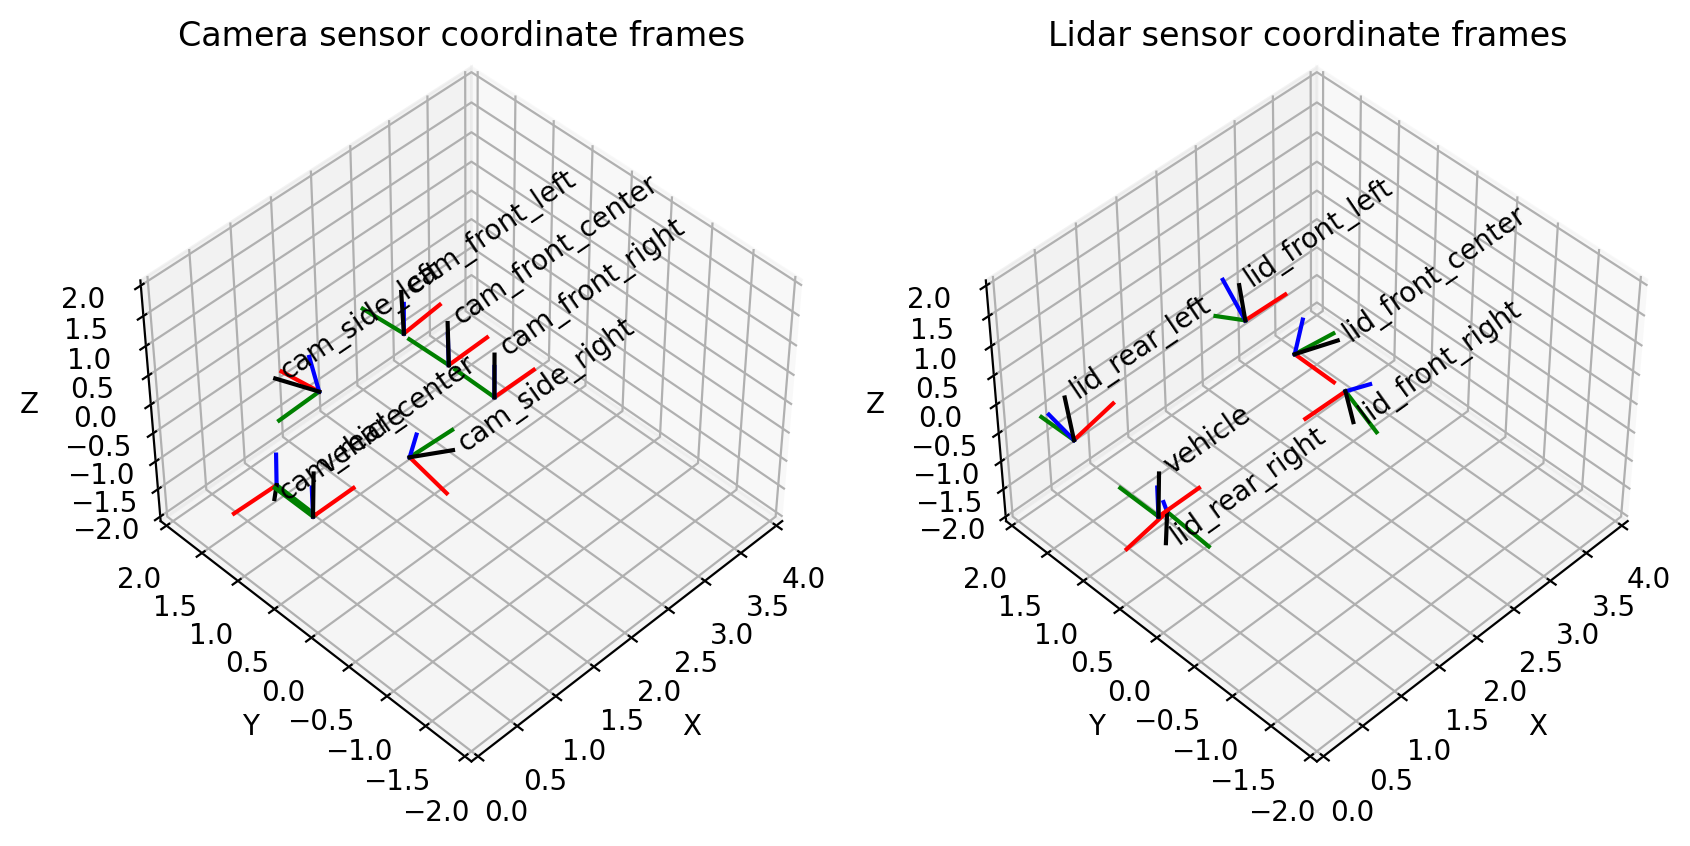

<Figure size 2000x2000 with 0 Axes>

In [15]:
# Visualize the locations of the cameras with respect to the vehicle center.
# Note that (R, G, B) corresponds to (X, Y, Z) of the coordinate frame.
fig = plt.figure(figsize=(10,10), dpi=200)
cameras_ax = fig.add_subplot(1, 2, 1, projection='3d')
lidars_ax = fig.add_subplot(1, 2, 2, projection='3d')
ax = transform_manager.plot_frames_in("vehicle", ax=cameras_ax, s=0.5, show_name=True, whitelist=veh_and_camera)
cameras_ax.set_title("Camera sensor coordinate frames")

limit_m = 2
translation = [2, 0, 0]


# Visualize the locations of the cameras with respect to the vehicle center.
fig = plt.figure(figsize=(10,10), dpi=200)
ax = transform_manager.plot_frames_in("vehicle", ax=lidars_ax, s=0.5, show_name=True, whitelist=veh_and_lidar)
lidars_ax.set_title("Lidar sensor coordinate frames")

for ax in (cameras_ax, lidars_ax):
    ax.set_xlim((-limit_m + translation[0], limit_m + translation[0]))
    ax.set_ylim((-limit_m + translation[1], limit_m + translation[1]))
    ax.set_zlim((-limit_m + translation[2], limit_m + translation[2]))
    ax.view_init(45, 225) # You can play with this value to plot from different perspectives.
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

## Plotting 3D Labels and 2D Projections

Now that we know we're reading the sensor poses correctly based on the above plots,
lets overlay our point cloud and cuboid labels in a 3D plot.

A2D2 has already done all the conversions of your input dataset points so that they are relative to the
`cam_front_center` camera. It has also removed all points not in the cameras field of view. Let's treat
`cam_front_center` as our origin coordinate frame, and plot all points and labels relative to that coordinate frame.

In [ ]:
from a2d2_helpers import undistort_image, a2d2_box_to_transform_matrix_and_size, draw_2d_bounding_box, generate_color_map

# Pick a random scene from the dataset. 3D datasets are typically organized
# as a series of sequential timesteps where both 3D lidar data and 2D camera data
# are available.
scene_id = "20180807_145028"
frame_id = "000000091"
file_scene_prefix = scene_id.replace("_", "")
scene_path = Path(dataset_root_path) / "camera_lidar_semantic_bboxes" / scene_id
frame_image_path = scene_path / "camera" / "cam_front_center" / f"{file_scene_prefix}_camera_frontcenter_{frame_id}.png"
frame_lidar_path = scene_path / "lidar" / "cam_front_center" / f"{file_scene_prefix}_lidar_frontcenter_{frame_id}.npz"
frame_label_path = scene_path / "label3D" / "cam_front_center" / f"{file_scene_prefix}_label3D_frontcenter_{frame_id}.json"

# Load our frame labels, we'll use these to draw in our 3D view and to draw the 2D projections over the actual camera.
with open(frame_label_path) as f:
    labels = json.load(f)

# Load our frame image from the file system.
image_frame = cv2.imread(str(frame_image_path))
image_frame = cv2.cvtColor(image_frame, cv2.COLOR_BGR2RGB)

# Load our frame point cloud from the compressed NPZ format, grabbing the points and reflectance corresponding
# to those points. We'll use the reflectance to color our points in the 3D plot.
lidar_frame = np.load(str(frame_lidar_path))
points = lidar_frame["points"]
reflectance = lidar_frame["reflectance"]

fig = plt.figure(figsize=(20,10), dpi=200)
ax_3d = fig.add_subplot(1, 2, 1, projection='3d')
transform_manager.plot_frames_in("cam_front_center", ax=ax_3d, s=0.5, show_name=True, whitelist=["cam_front_center"])

# Plot our point cloud.
ax_3d.scatter(points[:,0], points[:,1], points[:,2], c=lidar_frame["reflectance"], s=0.1, marker=",")

# Plot our 3d labels projected to 2d (part of A2D2 dataset)
for box_id, values in labels.items():
    A2B, size = a2d2_box_to_transform_matrix_and_size(values)
    plot_utils.plot_box(ax_3d, size=size, A2B=A2B, alpha=0.4)
    plot_utils.Frame(A2B).add_frame(ax_3d)

# Image undistortion corrects for multiple camera imperfections that make a camera
# not behave like an ideal pinhole camera model. It's important we undistort here
# since the 2D labels A2D2 provides correspond to the undistorted image, not
# the distorted version.
undistorted_image = undistort_image(image_frame, "front_center", cams_lidars)
color_map = generate_color_map(labels)
for box_id, box in labels.items():
    draw_2d_bounding_box(undistorted_image, box["2d_bbox"], box["class"], color_map[box["class"]])

    
# Show image side by side.
ax_2d = fig.add_subplot(1, 2, 2)
ax_2d.imshow(undistorted_image)
ax_2d.set_title("Image with projected labels overlayed")


limit_m = 10
translation = [25, 0, 0]
ax_3d.set_xlim((-limit_m + translation[0], limit_m + translation[0]))
ax_3d.set_ylim((-limit_m + translation[1], limit_m + translation[1]))
ax_3d.set_zlim((-limit_m + translation[2], limit_m + translation[2]))
ax_3d.set_title("Point cloud view using point distance for coloration")
ax_3d.view_init(5, 180)

## Projection from 3D to 2D

For both labeling and training mixed-modality models, you need to provide your model
with details of how to map from 3D points to 2D points in camera frame.


This transformation from 3D to 2D is described by both the camera extrinsics (the position
and orientation of the camera in 3D space) as well as the [camera matrix](https://en.wikipedia.org/wiki/Camera_matrix) (the mapping
from 3D coordinate in camera coordinate system to a 2D pixel value).


This projection is done in four steps:

1. Transform points into camera coordinate system
2. Multiply each point by our camera matrix (and normalize)
3. Drop points outside of camera range
4. Color points by distance and overlay on camera image

In [ ]:
from a2d2_helpers import x_forward_to_z_foward

# Let's overlay the point cloud on the image frame using the camera extrinsics and intrinsics.
# This is useful to get right since it can help human labelers better visualize which points belong
# to which object classes when annotating.

plt.figure(figsize=(10, 10), dpi=200)

undistorted_image = undistort_image(image_frame, "front_center", cams_lidars)
points = lidar_frame["points"]
# Convert to homogenous coordinate system.
points = np.append(points, np.ones((points.shape[0], 1)), axis=1)

color_map = generate_color_map(labels)
for box_id, box in labels.items():
    draw_2d_bounding_box(undistorted_image, box["2d_bbox"], box["class"], color_map[box["class"]])

# Here we get our camera matrix that maps from 3D points in the camera coordinate system
# and projects them to 2D pixel locations.
camera_matrix = np.array(cams_lidars['cameras']['front_center']['CamMatrix']).reshape(3, 3)
camera_matrix = np.append(camera_matrix, np.zeros((camera_matrix.shape[0], 1)), axis=1)

# The cam_front_center_ext coordinate system is essentially just the cam_front_center coordinate system,
# but with the z-axis of the coordinate system facing the direction of the camera rather than
# the x-axis.
transform_manager.add_transform(
    "cam_front_center_ext",
    "vehicle",
    x_forward_to_z_foward(
        transform_manager.get_transform("cam_front_center", "vehicle")
    )
)

# Convert points from the camera pose frame to the camera extrinsics coordinate frame,
# that has z-forward, x-right, and y-down.
points_in_camera_ext = points @ transform_manager.get_transform("cam_front_center_ext", "cam_front_center")

# Now use the camera matrix to convert points from extrinsics coordinate frame to 2D image plane,
# https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/EPSRC_SSAZ/node3.html
projected_points = (camera_matrix @ points_in_camera_ext.T).T
projected_points[:, 0] /= projected_points[:, 2]
projected_points[:, 1] /= projected_points[:, 2]
points_in_image = projected_points

# Drop points outside of image viewport and behind camera plane
indices_to_drop = np.where((points_in_image[:, 0] < 0) |
                           (points_in_image[:, 1] < 0) |
                           (points_in_image[:, 0] > undistorted_image.shape[1]) | 
                           (points_in_image[:, 1] > undistorted_image.shape[0]) | 
                           (points_in_camera_ext[:, 2] < 0))[0]

points_in_image = np.delete(points_in_image, indices_to_drop, axis=0)

# Color based on z-distance from camera plane
colors = points_in_camera_ext[:,2]
colors = np.sqrt(colors)
colors = np.expand_dims(colors/max(colors), 1)
colors = np.hstack((colors, 1-colors, colors-colors))

plt.imshow(undistorted_image, cmap='gray', extent=(0, undistorted_image.shape[1], undistorted_image.shape[0], 0)) # left, right, bottom, top
plt.title("Point cloud overlaid on camera frame, colored by distance")


res = plt.scatter(points_in_image[:,0], points_in_image[:,1], s=0.5, alpha=0.5, c=colors)

# Conversion to SageMaker Ground Truth

<span style="color:red;font-size:22.0pt"> The SageMaker Ground Truth job launch will not be possible inside of an AWS Instructor led workshop, however you can run the cells in a personal account.</span>

<span style="color:red;font-size:18.0pt"> If in an AWS instructor led workshop you can run the cells up to "Create a labeling workteam" to generate the files you would need in order to launch a job.</span>

Now that we have visualized our data, and shown we can perform the projection from point cloud to image frame,
we can confidently convert our point clouds into [SageMaker Ground Truth's 3D format](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-point-cloud-multi-frame-input-data.html) to verify and adjust our labels.


We'll use the multi-frame [object tracking modality](TODO) to let us see all the point cloud frames in the same labeling task,
however since we are ultimately only doing object detection, we'll ignore object tracks ids before training.

(Image from Amazon SageMaker Ground Truth Documentation - https://docs.aws.amazon.com/sagemaker/latest/dg/sms-point-cloud.html)
![](https://docs.aws.amazon.com/sagemaker/latest/dg/images/pointcloud/gifs/semantic_seg/ss_paint_sf.gif)

## Generate a Sequence File

We'll convert our dataset to Ground Truth compatible formats and generate a sequence file that is used as input to SageMaker Ground Truth for labeling.

A sequence specifies a temporal series of point cloud frames. When a task is created using a sequence file, all point cloud frames in the sequence are sent to a worker to label. Your input manifest file will contain a single sequence per line. To learn more about the sequence input manifest format, see [Create a Point Cloud Frame Sequence Input Manifest](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-point-cloud-multi-frame-input-data.html).

If you want to use this script to create a frame input manifest file, which is required for 3D point cloud object tracking and semantic segmentation labeling jobs, you can modify the for-loop in the function convert_to_gt to produce the required content for source-ref-metadata. To learn more about the frame input manifest format (different from the above sequence manifest format), see [Create a Point Cloud Frame Input Manifest File](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-point-cloud-single-frame-input-data.html).

Now, let's download the script and run it on the A2D2 dataset to process the data you'll use for your labeling job.

In [ ]:
from os.path import splitext
from pathlib import Path
import glob
import shutil

def a2d2_scene_to_smgt_sequence_and_seq_label(a2d2_scene_path, smgt_assets_path, sequence_s3_uri, num_frames=30):
    """
    This function converts from an A2D2 scene to SageMaker Ground Truth format.
    
    https://docs.aws.amazon.com/sagemaker/latest/dg/sms-point-cloud-multi-frame-input-data.html
    """
    if not sequence_s3_uri.endswith("/"):
        sequence_s3_uri += "/"

    scene_id = a2d2_scene_path.rsplit("/", 1)[-1]
    
    smgt_assets_path = Path(smgt_assets_path)
    smgt_assets_path.mkdir(parents=True, exist_ok=True)

    # Get a list of all lidar, camera, and 3D labels for the scene.
    lidar_frames = [Path(pth) for pth in sorted(glob.glob(str(Path(a2d2_scene_path) / "lidar" / "cam_front_center" / "*.npz")))]
    camera_frames = [Path(pth) for pth in sorted(glob.glob(str(Path(a2d2_scene_path) / "camera" / "cam_front_center" / "*.png")))]
    label_frames = [Path(pth) for pth in sorted(glob.glob(str(Path(a2d2_scene_path) / "label3D" / "cam_front_center" / "*.json")))]
    
    # For each frame (a point in time with a synchronized lidar and camera reading), convert the frame to SageMaker Ground Truth format.
    frames = []
    for i, (lidar_frame, camera_frame) in enumerate(zip(lidar_frames, camera_frames)):
        if i >= num_frames:
            continue
        
        # Parse the timestamp from each file path and verify they match.
        ts_lidar = lidar_frame.stem.rsplit("_", 1)[-1]
        ts_camera = camera_frame.stem.rsplit("_", 1)[-1]
        assert ts_lidar == ts_camera
        
        # Convert points from a numpy array to an ascii format.
        # See - https://docs.aws.amazon.com/sagemaker/latest/dg/sms-point-cloud-raw-data-types.html for more details.
        points_txt_path = smgt_assets_path / (lidar_frame.stem + ".txt")
        if not points_txt_path.exists():
            lidar_frame_contents = np.load(lidar_frame)
            points = lidar_frame_contents["points"]
            np.savetxt(points_txt_path, points)
            
        # Perform undistortion of images using A2D2 helper `undistort_image`.
        # For Amazon SageMaker Ground Truth to correctly align 3D points with our 2D images, our images
        # need to be undisorted before ingestion, or undistortion parameters can be provided to SageMaker
        # Ground Truth directly. Here we perform undistortion ourselves using A2D2's helper function
        # `undistort_image`.
        camera_path = smgt_assets_path / f"undistort_{camera_frame.name}"
        image_frame = cv2.imread(str(camera_frame))
        undistorted_image = undistort_image(image_frame, "front_center", cams_lidars)
        cv2.imwrite(str(camera_path), undistorted_image)

        # Get the position and heading of the front camera as a single array.
        # The format of pq = [x, y, z, qw, qx, qy, qz] where (x, y, z) refer to object
        # position while the remaining (qw, qx, qy, qz) correspond to camera heading.
        camera_transform = transform_manager.get_transform("cam_front_center_ext", "vehicle")
        pq = pt.pq_from_transform(camera_transform)
        
        frames.append({
            "frame-no": i,
            "unix-timestamp": int(ts_lidar) / 1000.,
            "frame": points_txt_path.name,
            "format": "text/xyz",
            "ego-vehicle-pose": {
                # We'll ignore pose since A2D2 doesn't directly provide it in their object detection
                # dataset, however providing pose can improve interpolation. See Amazon SageMaker Ground Truth's
                # product documentation for more details: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-point-cloud-sensor-fusion-details.html
                "position": {
                    "x": 0,
                    "y": 0,
                    "z": 0,
                },
                "heading": {
                    "qw": 1,
                    "qx": 0,
                    "qy": 0,
                    "qz": 0,
                },
            },
            "images": [{
                "image-path": camera_path.name,
                "unix-timestamp": int(ts_lidar) / 1000.,
                "fx": camera_matrix[0, 0],
                "fy": camera_matrix[1, 1],
                "cx": camera_matrix[0, 2],
                "cy": camera_matrix[1, 2],
                "position": {
                    "x": pq[0],
                    "y": pq[1],
                    "z": pq[2],
                },
                "heading": {
                    "qw": pq[3],
                    "qx": pq[4],
                    "qy": pq[5],
                    "qz": pq[6],
                },
                "camera-model": "pinhole",
            }],
        })
        
    source_seq = {
      "seq-no": 1,
      "prefix": sequence_s3_uri,
      "number-of-frames": len(frames),
      "frames": frames,
    }
    with open(smgt_assets_path / "seq.json", "w") as f:
        json.dump(source_seq, f)
        
    with open(smgt_assets_path / "single.manifest", "w") as f:
        json.dump({
            "source-ref": sequence_s3_uri + "seq.json"
        }, f)
    
        
scene_id = "20180807_145028"
a2d2_scene_to_smgt_sequence_and_seq_label(
    a2d2_scene_path=f"{dataset_root_path}/camera_lidar_semantic_bboxes/20180807_145028",
    smgt_assets_path=f"smgt_converted/{scene_id}",
    sequence_s3_uri=f"s3://{bucket}/a2d2_smgt/{scene_id}_out",
    num_frames=3,
)

scene_upload_s3_prefix = f"s3://{bucket}/a2d2_smgt/{scene_id}_out"
!aws s3 sync smgt_converted/20180807_145028 {scene_upload_s3_prefix}

Now we can inspect a sequence file we created, note that it follows the SageMaker Ground Truth input format specification.

In [37]:
!aws s3 cp {scene_upload_s3_prefix}/seq.json /tmp/seq.json
!cat /tmp/seq.json | jq

download: s3://sagemaker-us-east-1-322552456788/a2d2_smgt/20180807_145028_out/seq.json to ../../../../../tmp/seq.json
{
  "seq-no": 1,
  "prefix": "s3://sagemaker-us-east-1-322552456788/a2d2_smgt/20180807_145028_out/",
  "number-of-frames": 5,
  "frames": [
    {
      "frame-no": 0,
      "unix-timestamp": 0.091,
      "frame": "20180807145028_lidar_frontcenter_000000091.txt",
      "format": "text/xyz",
      "ego-vehicle-pose": {
        "position": {
          "x": 0,
          "y": 0,
          "z": 0
        },
        "heading": {
          "qw": 1,
          "qx": 0,
          "qy": 0,
          "qz": 0
        }
      },
      "images": [
        {
          "image-path": "undistort_20180807145028_camera_frontcenter_000000091.png",
          "unix-timestamp": 0.091,
          "fx": 1687.3369140625,
          "fy": 1783.428466796875,
          "cx": 965.4341405582381,
          "cy": 684.4193604186803,
          "position": {
            "x": 1.711045726422736,
            "y":

## Identify Resources for Labeling Job

In [23]:
task_type = "3DPointCloudObjectTracking"

### Specify Human Task UI ARN

The following will be used to identify the HumanTaskUiArn. When you create a 3D point cloud labeling job, 
Ground Truth provides a worker UI that is specific to your task type. You can learn more about this UI
and the assistive labeling tools that Ground Truth provides for Object Tracking on the Object Tracking task type page.

In [24]:
human_task_ui_arn = (
    f"arn:aws:sagemaker:{region}:394669845002:human-task-ui/PointCloudObjectTracking"
)
human_task_ui_arn

'arn:aws:sagemaker:us-east-1:394669845002:human-task-ui/PointCloudObjectTracking'

### Label Category Configuration File

Your label category configuration file is used to specify labels, or classes, for your labeling job.

When you use the object detection or object tracking task types, you can also include label attributes in your label category configuration file. Workers can assign one or more attributes you provide to annotations to give more information about that object. For example, you may want to use the attribute occluded to have workers identify when an object is partially obstructed.

Let's look at an example of the label category configuration file for an object detection or object tracking labeling job.


In [25]:
!wget https://aws-ml-blog.s3.amazonaws.com/artifacts/gt-point-cloud-demos/label-category-config/label-category.json

--2021-11-17 23:24:32--  https://aws-ml-blog.s3.amazonaws.com/artifacts/gt-point-cloud-demos/label-category-config/label-category.json
Resolving aws-ml-blog.s3.amazonaws.com (aws-ml-blog.s3.amazonaws.com)... 52.216.109.131
Connecting to aws-ml-blog.s3.amazonaws.com (aws-ml-blog.s3.amazonaws.com)|52.216.109.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 927 [application/json]
Saving to: ‘label-category.json’

100%[======================================>] 927         --.-K/s   in 0s      

2021-11-17 23:24:33 (42.1 MB/s) - ‘label-category.json’ saved [927/927]



In [26]:
with open("label-category.json", "r") as j:
    json_data = json.load(j)
    print(
        "\nA label category configuration file: \n\n",
        json.dumps(json_data, indent=4, sort_keys=True),
    )


A label category configuration file: 

 {
    "categoryGlobalAttributes": [
        {
            "description": "global attribute that applies to all label categories",
            "enum": [
                "Partial",
                "Full"
            ],
            "name": "Occlusion",
            "type": "string"
        }
    ],
    "document-version": "2020-03-01",
    "instructions": {
        "fullInstruction": "Use this area to add more detailed worker instructions.",
        "shortInstruction": "Draw a tight cuboid around objects after you select a category."
    },
    "labels": [
        {
            "attributes": [
                {
                    "enum": [
                        "SUV",
                        "Sedan"
                    ],
                    "name": "Type",
                    "type": "string"
                }
            ],
            "label": "Car"
        },
        {
            "attributes": [
                {
                    "enum": 

Now let's send this label category file to S3 where SageMaker Ground Truth can access it. The next cell defines the pre and post annotation lambdas used for the labeling task. These are predefined lambda functions, we simply need to specify the right one according the region we are launching our labeling job in.

In [27]:
!aws s3 cp label-category.json s3://{bucket}/label-category.json
label_category_config_s3uri = f's3://{bucket}/label-category.json'

upload: ./label-category.json to s3://sagemaker-us-east-1-322552456788/label-category.json


In [28]:
ac_arn_map = {
    "us-west-2": "081040173940",
    "us-east-1": "432418664414",
    "us-east-2": "266458841044",
    "eu-west-1": "568282634449",
    "ap-northeast-1": "477331159723",
}

prehuman_arn = "arn:aws:lambda:{}:{}:function:PRE-{}".format(region, ac_arn_map[region], task_type)
acs_arn = "arn:aws:lambda:{}:{}:function:ACS-{}".format(region, ac_arn_map[region], task_type)

### Create a labeling workteam

You will create some of the resources you need to launch a Ground Truth labeling job in this notebook. You must create the following resources before executing this notebook:

* A work team. A work team is a group of workers that complete labeling tasks. If you want to preview the worker UI and execute the labeling task you will need to create a private work team, add yourself as a worker to this team, and provide the work team ARN below. This [GIF](images/create-workteam-loop.gif) demonstrates how to quickly create a private work team on the Amazon SageMaker console. If you do not want to use a private or vendor work team ARN, set `private_work_team` to `False` to use the Amazon Mechanical Turk workforce. To learn more about private, vendor, and Amazon Mechanical Turk workforces, see [Create and Manage Workforces
](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-management.html).

In [34]:
workteam_arn = '<<ADD WORK TEAM ARN HERE>>'

print(f'This notebook will use the work team ARN: {workteam_arn}')

# Make sure workteam arn is populated if private work team is chosen
assert (workteam_arn != '<<ADD WORK TEAM ARN HERE>>')

This notebook will use the work team ARN: arn:aws:sagemaker:us-east-1:322552456788:workteam/private-crowd/downsampling


### Launch the labeling job

<span style="color:red;font-size:16.0pt"> If you are in an AWS instructor led workshop you will not be able to run this section, however, if you are running this in your own account you can uncomment the below cells and launch a labeling job.</span>

In the following cell you configure the labeling job request. To learn more about the parameters used to configure a labeling job, see [Create a Labeling Job (API)](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-create-labeling-job-api.html).

In [35]:
# import boto3

# sagemaker_cl = boto3.client("sagemaker")

# now = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
# job_name = f"a2d2-{now}"

# request = {
#     "LabelingJobName": job_name,
#     "LabelAttributeName": f"{job_name}-ref",
#     "InputConfig": {
#         "DataSource": {
#             "S3DataSource": {
#                 "ManifestS3Uri": f"{scene_upload_s3_prefix}/single.manifest" 
#             }
#         },
#         "DataAttributes": {
#             "ContentClassifiers": []
#         }
#     },
#     "OutputConfig": {
#         "S3OutputPath": f"s3://{bucket}/smgt_output",
#         "KmsKeyId": ""
#     },
#     "RoleArn": role,
#     "LabelCategoryConfigS3Uri": label_category_config_s3uri,
#     "HumanTaskConfig": {
#         "WorkteamArn": workteam_arn,
#         "UiConfig": {
#             "HumanTaskUiArn": human_task_ui_arn,
#         },
#         "PreHumanTaskLambdaArn": prehuman_arn,
#         "TaskKeywords": [
#             "Point cloud",
#             "tracking"
#         ],
#         "TaskTitle": "Point cloud object tracking: MyTest",
#         "TaskDescription": "Annotate objects to track their movement across 3D point cloud frames",
#         "NumberOfHumanWorkersPerDataObject": 1,
#         "TaskTimeLimitInSeconds": 259200,
#         "TaskAvailabilityLifetimeInSeconds": 864000,
#         "MaxConcurrentTaskCount": 1000,
#         "AnnotationConsolidationConfig": {
#             "AnnotationConsolidationLambdaArn": acs_arn
#         }
#     },
# }

# res = sagemaker_cl.create_labeling_job(
#     **request
# )
# res

{'LabelingJobArn': 'arn:aws:sagemaker:us-east-1:322552456788:labeling-job/a2d2-2021-11-17-23-25-31',
 'ResponseMetadata': {'RequestId': 'be46e31e-4e7d-4110-be0a-05ed6bb0d0d1',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'be46e31e-4e7d-4110-be0a-05ed6bb0d0d1',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '99',
   'date': 'Wed, 17 Nov 2021 23:25:31 GMT'},
  'RetryAttempts': 0}}

### Enter worker portal

Run the following cell to see the worker portal URL of your private workforce. Use this URL to login to the worker portal to see your labeling tasks. See the 3D point cloud worker instructions to learn more about the feature you'll see in the worker UI.

In [39]:
# workforce = sagemaker_cl.describe_workforce(WorkforceName="default")
# worker_portal_url = workforce["Workforce"]["SubDomain"]
# print(f"Sign-in by going here: https://{worker_portal_url}")

Sign-in by going here: https://cwv3raulzu.labeling.us-east-1.sagemaker.aws


## Conclusion

In this notebook, we downloaded the A2D2 dataset, reviewed its contents, visualized the 2D and 3D data, and launched a SageMaker Ground Truth labeling job to label our data.


Now that we understand our data and its labels, we'll move on to the `sagemaker_training.ipynb` notebook to train a 3D object detection model!